In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
import os 

PATH = '.\\..\\dataset\\micro_expressions'
PATH

'.\\..\\dataset\\micro_expressions'

In [5]:
# Conferir o número total de imagens

import pathlib 

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

print(train_dir)
print(test_dir)

.\..\dataset\micro_expressions\train
.\..\dataset\micro_expressions\test


In [6]:
import pathlib 

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

6938
1700


In [7]:
# Construção e pré-processamento do Dataset a partir das imagens em disco
# Existem 5 pastas para cada uma das classes
# A informação nas pastas não está dividida em conjuntos de treino e validação
# Consultar detalhes na aula anterior e aqui: https://www.tensorflow.org/tutorials/load_data/images

batch_size = 32
IMG_SIZE = (80, 80)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.15,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.15,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None, 
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 6938 files belonging to 7 classes.
Using 5898 files for training.
Found 6938 files belonging to 7 classes.
Using 1040 files for validation.
Found 1700 files belonging to 7 classes.


In [8]:
# Obter alguma informação sobre o dataset

#Cardinalidade 
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())
print('Cardinalidade Test: ', test_ds.cardinality().numpy())

print('Classes: ', class_names)


# Explicar o valor obtido para a cardinalidade dos conjuntos 


Cardinalidade Treino:  185
Cardinalidade Validacão:  33
Cardinalidade Test:  54
Classes:  ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


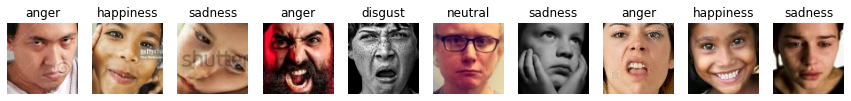

In [9]:
# Visualizar algumas imagens do Dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("float32")) #pode ser transformado num array numpy 
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Base model without data augmentation 

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 3))

x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(120, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(90, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(60, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 120)       69240     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 120)         0     

In [10]:
# Compilar o modelo
# Utilize o otimizador ADAM com parametrização default e a accuracy como métrica
# Defina a função de loss L que considerar mais apropriada

L = keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
) 

Epoch 1/50
174/174 [==============================] - 9s 12ms/step - loss: 1.8342 - accuracy: 0.2547 - val_loss: 1.6470 - val_accuracy: 0.3980
Epoch 2/50
174/174 [==============================] - 1s 8ms/step - loss: 1.6050 - accuracy: 0.3888 - val_loss: 1.4563 - val_accuracy: 0.4895
Epoch 3/50
174/174 [==============================] - 1s 7ms/step - loss: 1.4909 - accuracy: 0.4426 - val_loss: 1.2980 - val_accuracy: 0.5256
Epoch 4/50
174/174 [==============================] - 1s 7ms/step - loss: 1.3733 - accuracy: 0.4914 - val_loss: 1.2167 - val_accuracy: 0.5573
Epoch 5/50
174/174 [==============================] - 1s 7ms/step - loss: 1.2842 - accuracy: 0.5309 - val_loss: 1.1656 - val_accuracy: 0.5898
Epoch 6/50
174/174 [==============================] - 1s 7ms/step - loss: 1.2195 - accuracy: 0.5577 - val_loss: 1.1528 - val_accuracy: 0.5934
Epoch 7/50
174/174 [==============================] - 1s 7ms/step - loss: 1.1333 - accuracy: 0.5844 - val_loss: 1.0984 - val_accuracy: 0.6265
Epoch

(accuracy    0.874977
 dtype: float64,
 val_accuracy    0.743331
 dtype: float64)

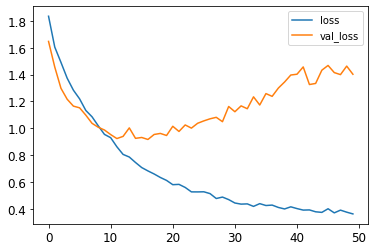

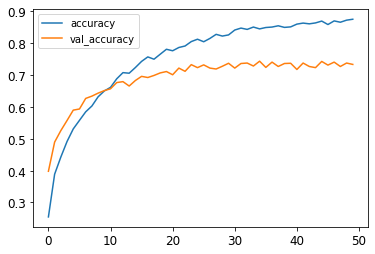

In [12]:
# Visualizar os resultados
# Visualização da evolução da accurary e da loss

import pandas as pd 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

history_frame.loc[:, [ 'accuracy']].max(), history_frame.loc[:, [ 'val_accuracy']].max()

In [13]:
model.evaluate(test_ds)

54/54 [==============================] - 1s 10ms/step - loss: 1.6645 - accuracy: 0.7106


[1.6645417213439941, 0.7105882167816162]

In [138]:
import random  

transformations = [
    layers.RandomFlip("horizontal",input_shape=(80, 80, 3)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant" ,input_shape=(80, 80, 3)),
    layers.RandomZoom(0.2,  fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomRotation(0.05, fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomContrast(factor=[0.5, 1.3],input_shape=(80, 80, 3)),
    layers.GaussianNoise(0.03)
]     

def customDataAugmentationLayer(input):
    if random.random() > 0.5 :  
        return random.choice(transformations)(input)
    else:  
        result = input 
        for transformation in transformations:
            result = transformation(result)
        
        return result

dataAug = layers.Lambda(lambda input: customDataAugmentationLayer(input))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

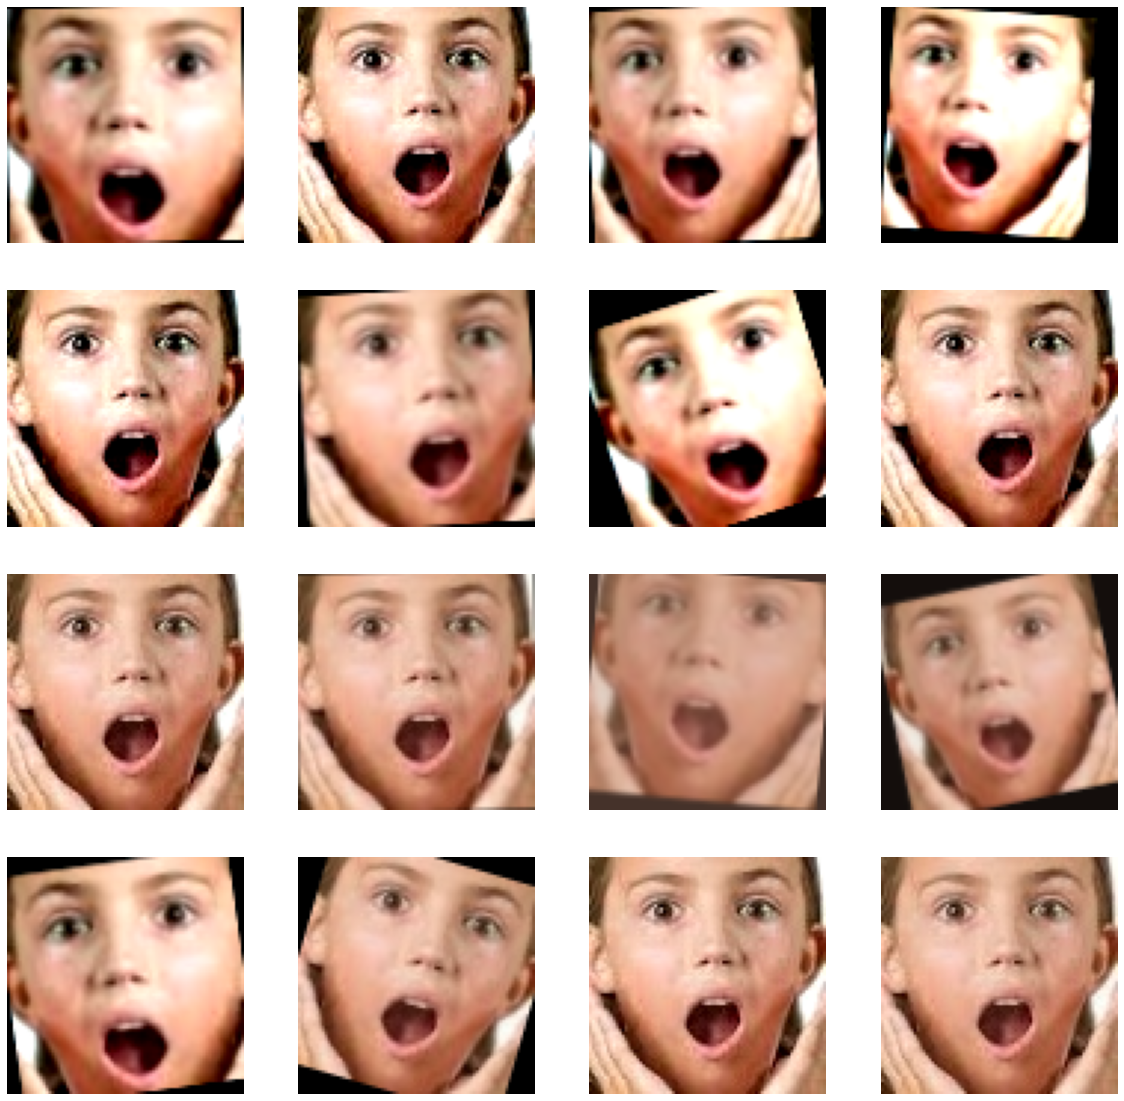

In [139]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(16):
        augmented_images = dataAug(images)
        #augmented_images = CustomDataAugmentationLayer()(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[12].numpy().astype("float32"))
        plt.axis("off")


## Rede melhor

In [165]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 3))

x = keras.Sequential(transformations)(inputs)
#x = dataAug(inputs)

x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3,  padding='same',  use_bias=False)(x) 
x = layers.Activation("relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)


x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(256, 3,  padding='same',  use_bias=False)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.1)(x)


x = layers.Flatten()(x) 
x = layers.BatchNormalization()(x)  
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(60, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(30, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)

outputs = keras.layers.Dense(7, activation="softmax")(x) 

modelWithAugmentation = keras.Model(inputs=inputs, outputs=outputs)
modelWithAugmentation.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128   

In [11]:
filepath = 'my_best_model.hdf5'

In [166]:
# Compilar e treinar
from keras.callbacks import ModelCheckpoint
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=0, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [167]:
L = keras.losses.SparseCategoricalCrossentropy()

modelWithAugmentation.compile(loss=L, optimizer="adam", metrics=["accuracy"])

history = modelWithAugmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=callbacks
)

Epoch 1/200
185/185 [==============================] - 10s 43ms/step - loss: 2.1707 - accuracy: 0.2033 - val_loss: 2.3325 - val_accuracy: 0.1750
Epoch 2/200
185/185 [==============================] - 7s 40ms/step - loss: 1.8274 - accuracy: 0.3074 - val_loss: 2.5314 - val_accuracy: 0.1779
Epoch 3/200
185/185 [==============================] - 7s 38ms/step - loss: 1.6521 - accuracy: 0.3827 - val_loss: 1.5036 - val_accuracy: 0.4500
Epoch 4/200
185/185 [==============================] - 7s 38ms/step - loss: 1.4956 - accuracy: 0.4486 - val_loss: 1.3199 - val_accuracy: 0.5192
Epoch 5/200
185/185 [==============================] - 7s 38ms/step - loss: 1.4125 - accuracy: 0.4807 - val_loss: 1.3006 - val_accuracy: 0.5183
Epoch 6/200
185/185 [==============================] - 7s 38ms/step - loss: 1.2997 - accuracy: 0.5365 - val_loss: 1.3139 - val_accuracy: 0.5260
Epoch 7/200
185/185 [==============================] - 7s 38ms/step - loss: 1.2564 - accuracy: 0.5504 - val_loss: 1.2305 - val_accuracy

(accuracy    0.958291
 dtype: float64,
 val_accuracy    0.841346
 dtype: float64)

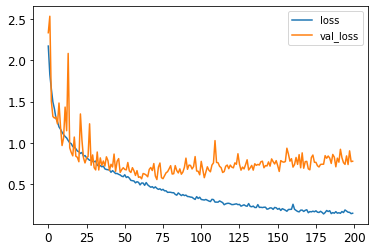

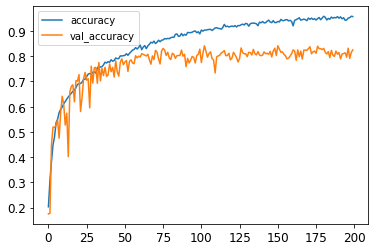

In [170]:
import pandas as pd 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

history_frame.loc[:, [ 'accuracy']].max(), history_frame.loc[:, [ 'val_accuracy']].max()

In [12]:
from keras.models import load_model  
model = load_model(filepath )
model.evaluate(test_ds)

54/54 [==============================] - 9s 13ms/step - loss: 0.6347 - accuracy: 0.8176


[0.6346720457077026, 0.8176470398902893]

[3]
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
['happiness']


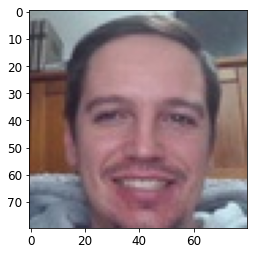

In [34]:
from keras.preprocessing import image
img = image.load_img("im1.jpg", target_size=(80,80))  
plt.imshow(image.img_to_array(img) / 255)
x=image.img_to_array(img)
x= x/ 255.
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=16)

print(classes.argmax(axis=-1))
print(class_names)
print(np.array(class_names)[classes.argmax(axis=-1)])

[5]
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
['sadness']


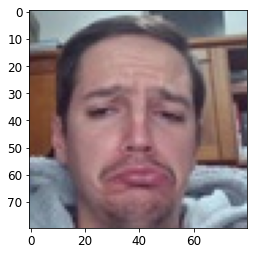

In [35]:
img = image.load_img("im2.jpg", target_size=(80,80))  
plt.imshow(image.img_to_array(img) / 255)
x=image.img_to_array(img)
x= x/ 255.
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=16)

print(classes.argmax(axis=-1))
print(class_names)
print(np.array(class_names)[classes.argmax(axis=-1)])